# Rosenbrock banana

Here, we perform optimization for the Rosenbrock banana function, which does not require an AMICI model. In particular, we try several ways of specifying derivative information.

In [1]:
import pypesto
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

## Define the objective and problem

In [2]:
# first type of objective
objective1 = pypesto.Objective(fun=sp.optimize.rosen, 
                               grad=sp.optimize.rosen_der, 
                               hess=sp.optimize.rosen_hess)

# second type of objective
def rosen2(x):
    return sp.optimize.rosen(x), sp.optimize.rosen_der(x), sp.optimize.rosen_hess(x)
objective2 = pypesto.Objective(fun=rosen2, grad=True, hess=True)

dim_full = 10
lb = -5 * np.ones((dim_full, 1))
ub = 5 * np.ones((dim_full, 1))

problem1 = pypesto.Problem(objective=objective1, lb=lb, ub=ub)
problem2 = pypesto.Problem(objective=objective2, lb=lb, ub=ub)

## Illustration

In [3]:
x = np.arange(-2, 2, 0.1)
y = np.arange(-2, 2, 0.1)
x, y = np.meshgrid(x, y)
z = np.zeros_like(x)
for j in range(0, x.shape[0]):
    for k in range(0, x.shape[1]):
        z[j,k] = objective1([x[j,k], y[j,k]], (0,))     

Text(0.5, 0.92, 'cost function values')

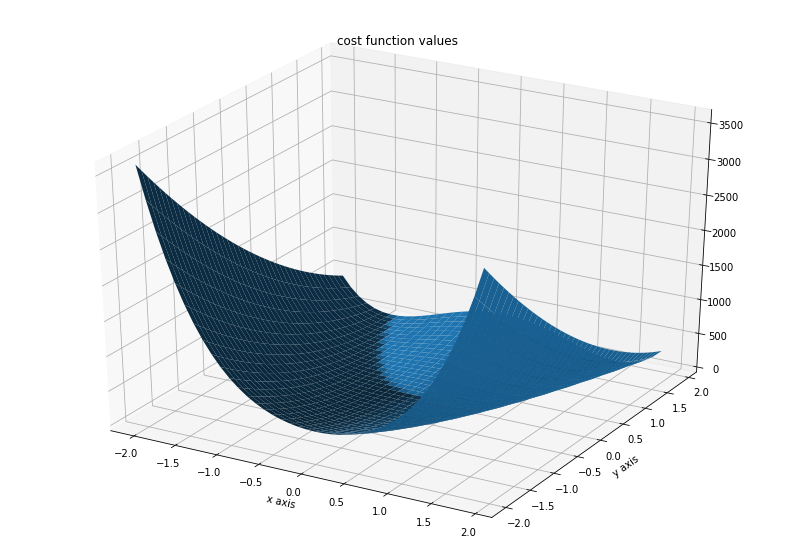

In [4]:
fig = plt.figure()
fig.set_size_inches(*(14,10))
ax = plt.axes(projection='3d')
ax.plot_surface(X=x, Y=y, Z=z)
plt.xlabel('x axis')
plt.ylabel('y axis')
ax.set_title('cost function values')

## Run optimization

In [5]:
# create different optimizers
optimizer_bfgs = pypesto.ScipyOptimizer(method='l-bfgs-b')
optimizer_tnc = pypesto.ScipyOptimizer(method='TNC')
optimizer_dogleg = pypesto.ScipyOptimizer(method='dogleg')

# set number of starts
n_starts = 20

# save optimizer trace
history_options = pypesto.OptimizerHistoryOptions(trace_record=True)

# Run optimizaitons for different optimzers
result1_bfgs = pypesto.minimize(
    problem=problem1, optimizer=optimizer_bfgs,
    n_starts=n_starts, history_options=history_options)
result1_tnc = pypesto.minimize(
    problem=problem1, optimizer=optimizer_tnc,
    n_starts=n_starts, history_options=history_options)
result1_dogleg = pypesto.minimize(
    problem=problem1, optimizer=optimizer_dogleg,
    n_starts=n_starts, history_options=history_options)

# Optimize second type of objective
result2 = pypesto.minimize(problem=problem2, optimizer=optimizer_tnc, n_starts=n_starts)

## Visualize and compare optimization results

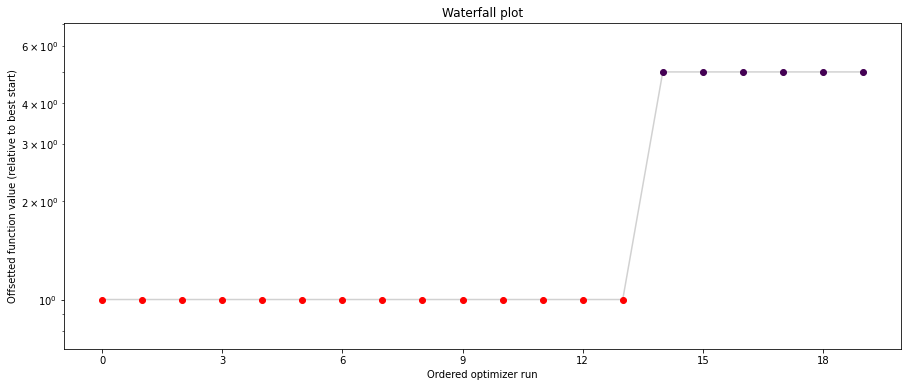

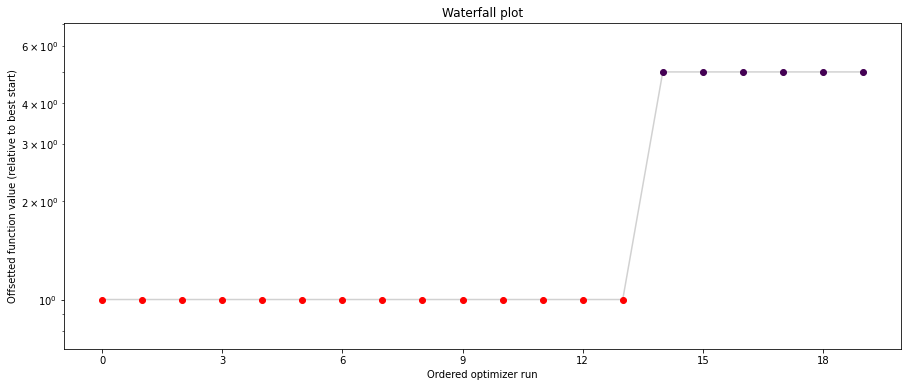

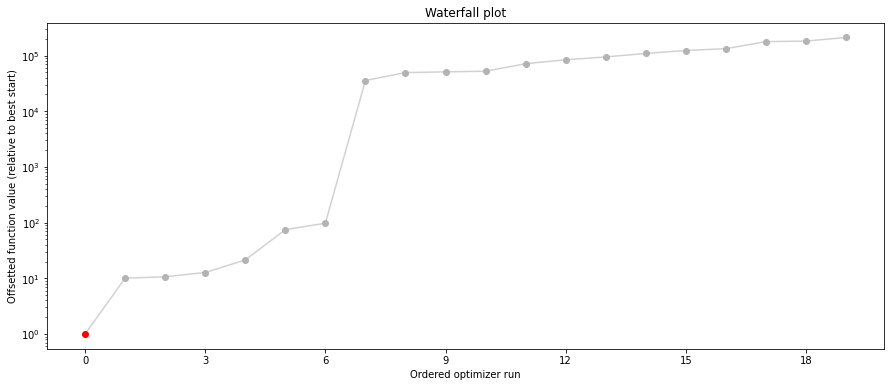

In [6]:
import pypesto.visualize

# plot separated waterfalls
pypesto.visualize.waterfall(result1_bfgs, size=(15,6))
pypesto.visualize.waterfall(result1_tnc, size=(15,6))
pypesto.visualize.waterfall(result1_dogleg, size=(15,6))

We can now have a closer look, which method perfomred better: Let's first compare bfgs and TNC, since both methods gave good results. How does the fine convergence look like?

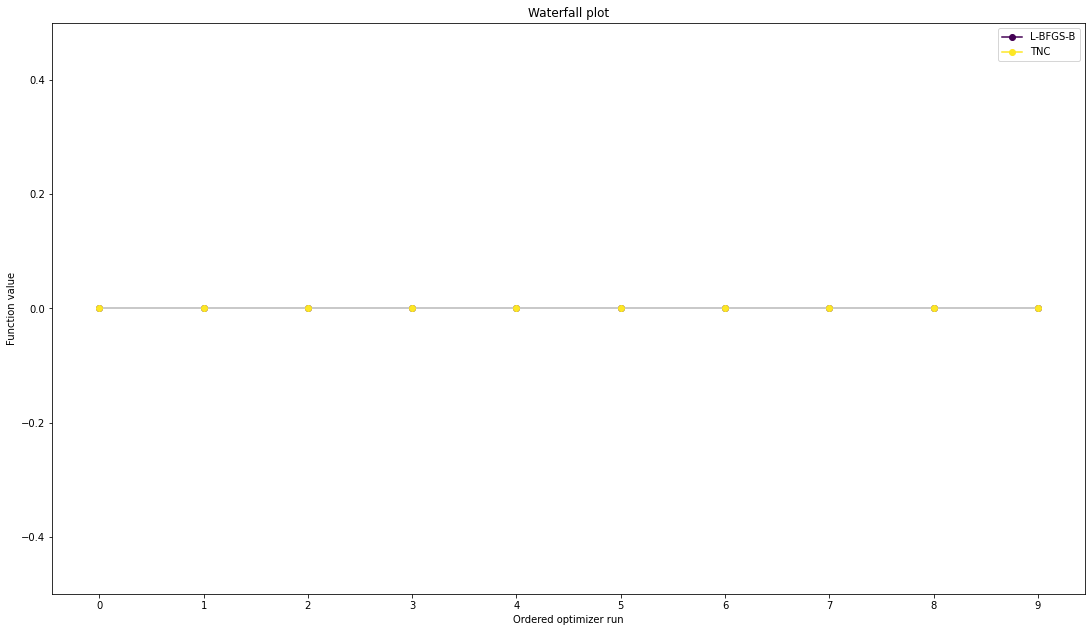

In [7]:
# plot one list of waterfalls
pypesto.visualize.waterfall([result1_bfgs, result1_tnc],
                            legends=['L-BFGS-B', 'TNC'],
                            start_indices=10,
                            scale_y='lin')

Second optimum at: 3.9865791128785575


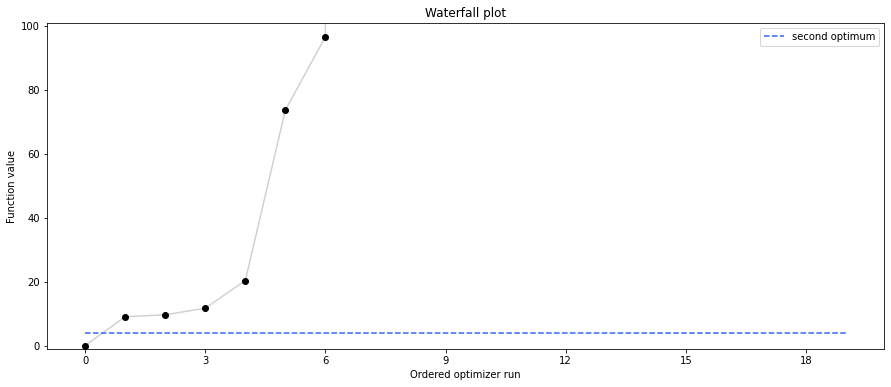

In [8]:
# retrieve second optimum
all_x = result1_bfgs.optimize_result.get_for_key('x')
all_fval = result1_bfgs.optimize_result.get_for_key('fval')
x = all_x[19]
fval = all_fval[19]
print('Second optimum at: ' + str(fval))

# create a reference point from it
ref = {'x': x, 'fval': fval, 'color': [
    0.2, 0.4, 1., 1.], 'legend': 'second optimum'}
ref = pypesto.visualize.create_references(ref)

# new waterfall plot with reference point for second optimum
pypesto.visualize.waterfall(result1_dogleg, size=(15,6), 
                            scale_y='lin', y_limits=[-1, 101],
                            reference=ref, colors=[0., 0., 0., 1.])

## Visualize parameters

There seems to be a second local optimum. We want to see whether it was also found by the dogleg method

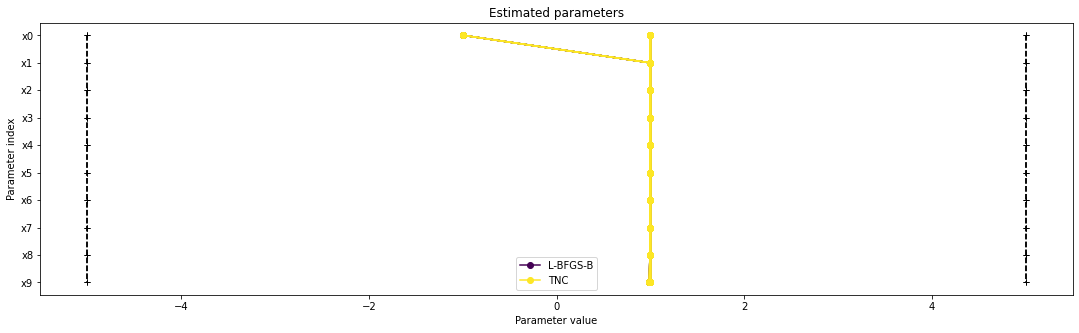

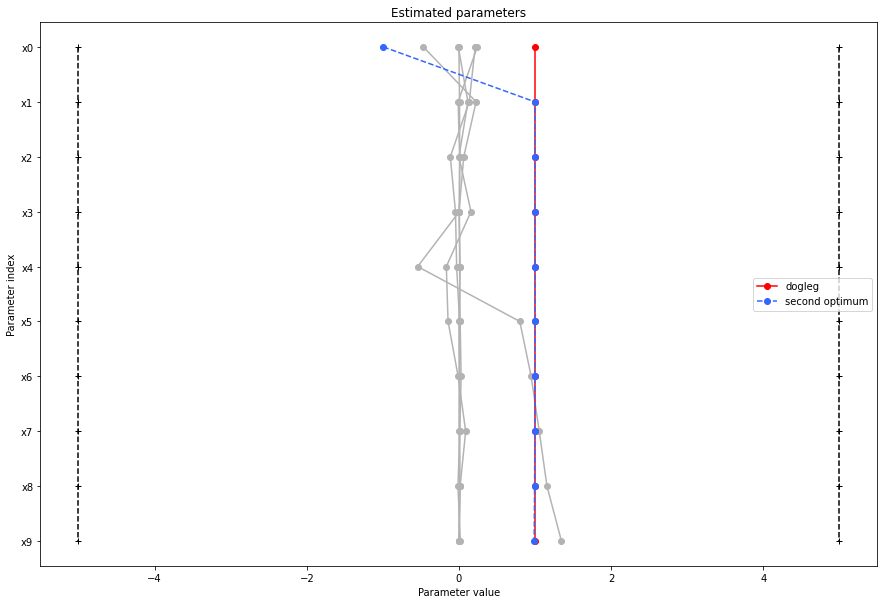

In [9]:
pypesto.visualize.parameters([result1_bfgs, result1_tnc],
                            legends=['L-BFGS-B', 'TNC'],
                            balance_alpha=False)
pypesto.visualize.parameters(result1_dogleg,
                             legends='dogleg',
                             reference=ref,
                             size=(15,10),
                             start_indices=[0, 1, 2, 3, 4, 5],
                             balance_alpha=False)

## Optimizer history

Let's compare optimzer progress over time.

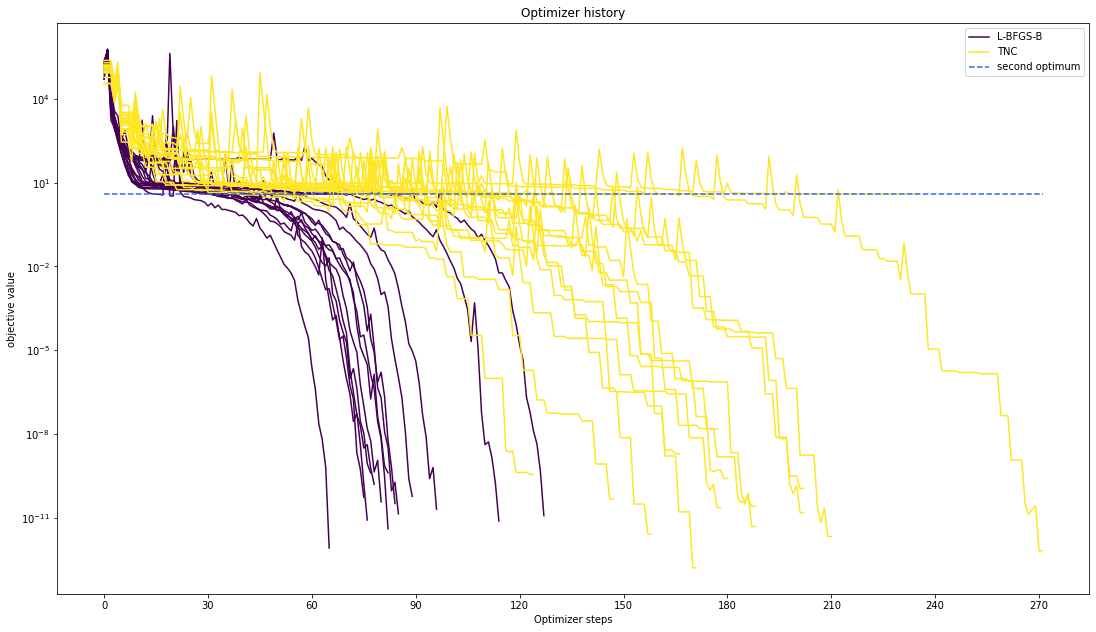

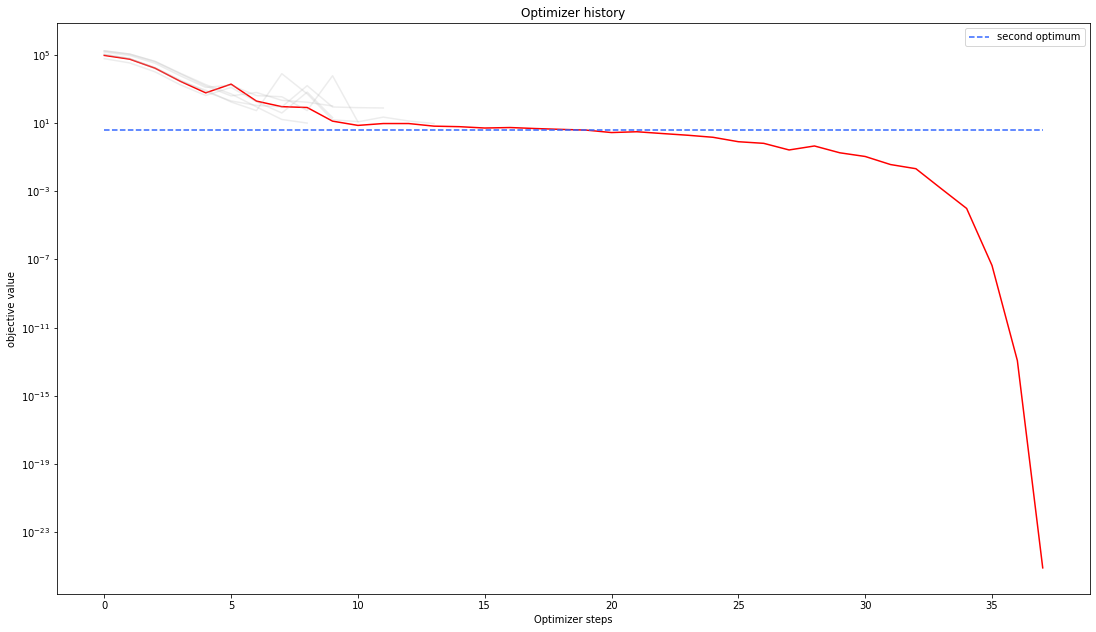

In [10]:
# plot one list of waterfalls
pypesto.visualize.optimizer_history([result1_bfgs, result1_tnc],
                                    legends=['L-BFGS-B', 'TNC'],
                                    reference=ref)
# plot one list of waterfalls
pypesto.visualize.optimizer_history(result1_dogleg,
                                    reference=ref)

We can also visualize this usign other scalings or offsets...

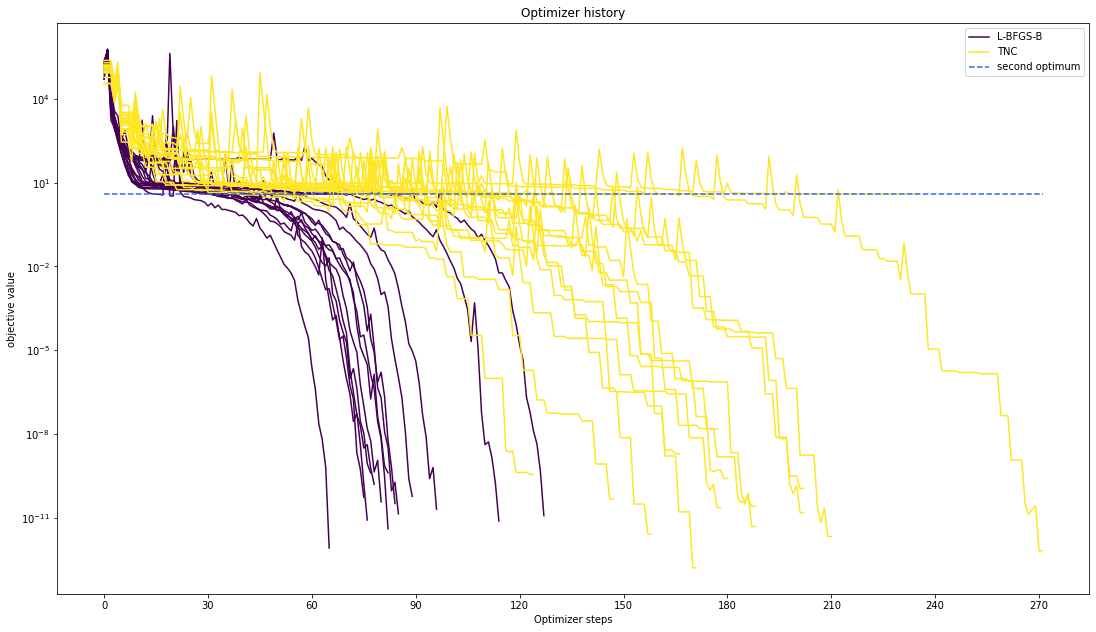

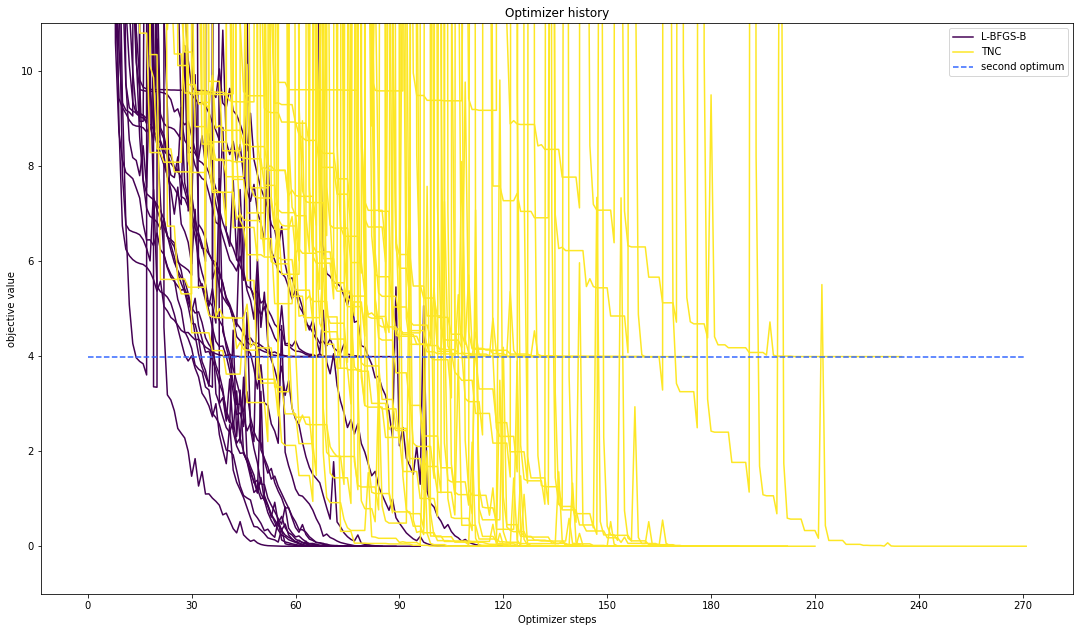

In [11]:
# plot one list of waterfalls
pypesto.visualize.optimizer_history([result1_bfgs, result1_tnc],
                                    legends=['L-BFGS-B', 'TNC'],
                                    reference=ref,
                                    offset_y=0.)

# plot one list of waterfalls
pypesto.visualize.optimizer_history([result1_bfgs, result1_tnc],
                                    legends=['L-BFGS-B', 'TNC'],
                                    reference=ref,
                                    scale_y='lin',
                                    y_limits=[-1., 11.])

## Compute profiles

The profiling routine needs a problem, a results object and an optimizer.

Moreover it accepts an index of integer (profile_index), whether or not a profile should be computed.

Finally, an integer (result_index) can be passed, in order to specify the local optimum, from which profiling should be started.

In [12]:
# compute profiles
profile_options = pypesto.ProfileOptions(min_step_size=0.0005,
    delta_ratio_max=0.05,
    default_step_size=0.005,
    ratio_min=0.03)

result1_tnc = pypesto.parameter_profile(
    problem=problem1,
    result=result1_tnc,
    optimizer=optimizer_tnc,
    profile_index=np.array([1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]),
    result_index=0,
    profile_options=profile_options)

# compute profiles from second optimum
result1_tnc = pypesto.parameter_profile(
    problem=problem1,
    result=result1_tnc,
    optimizer=optimizer_tnc,
    profile_index=np.array([1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]),
    result_index=19,
    profile_options=profile_options)

## Visualize and analyze results

pypesto offers easy-to-use visualization routines:

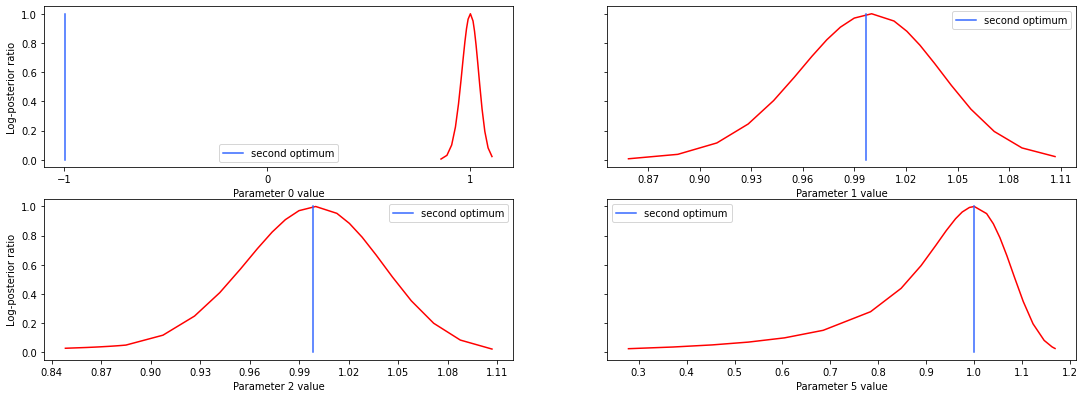

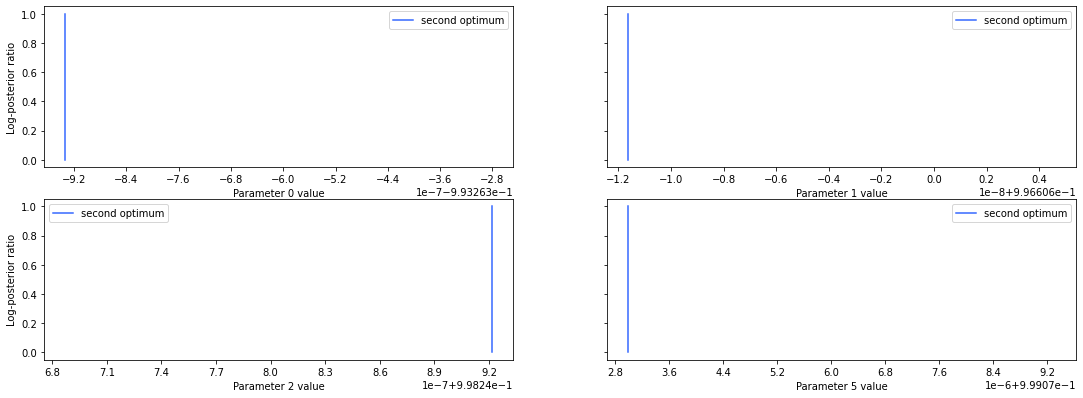

In [13]:
# specify the parameters, for which profiles should be computed
ax = pypesto.visualize.profiles(result1_tnc, profile_indices = [0,1,2,5], 
                           reference=ref, profile_list_id=0)
# plot profiles again, now from second optimum
ax = pypesto.visualize.profiles(result1_tnc, profile_indices = [0,1,2,5], 
                           reference=ref, profile_list_id=1)

If the result needs to be examined in more detail, it can easily be exported as a pandas.DataFrame:

In [14]:
result1_tnc.optimize_result.as_dataframe(['fval', 'n_fval', 'n_grad', 
                                          'n_hess', 'n_res', 'n_sres', 'time'])

,fval,n_fval,n_grad,n_hess,n_res,n_sres,time
0,1.630911e-13,172,172,0,0,0,4.119901
1,6.710800e-13,272,272,0,0,0,10.957177
2,2.179423e-12,211,211,0,0,0,13.052060
3,2.642846e-12,159,159,0,0,0,1329.564208
4,4.869099e-12,189,189,0,0,0,8.500741
5,1.539139e-11,203,203,0,0,0,9.472038
6,2.346607e-11,179,179,0,0,0,7.146906
7,2.630403e-11,189,189,0,0,0,10.738858
8,4.688212e-11,148,148,0,0,0,3.432399
9,1.141360e-10,203,203,0,0,0,7.929183
